In [5]:
from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan
import pickle
import warnings

warnings.filterwarnings('ignore')

# Glicko2: A Probabilistic Chess Rating Framework

**[Introduction](#Introduction)**  
**[Data](#Data)**  
**[Model](#Model)**  
**[Inference](#Inference)**  
**[Criticism](#Criticism)**  
**[Re-Iteration](#Re-Iteration)**   

# Introduction <a id='Introduction'></a>

Chess ratings, and rating systems in general, have important implications in head-to-head competitions. Teams and players often get seeded in tournaments or qualify for certain events based on their ratings. Similarly, ratings are also used for match-making, ensuring fairness in such competitions. Thus, it is desirable to have bespoke, probabilistic rating systems that we can explain. In this project, we will use Box's framework to explore the Glicko2 rating system with a focus on inference methods.

![Box's Loop](./img/boxsloop.png)

## Data <a id='Data'></a>

Our data set, which is taken from the [Kaggle Deloitte/FIDE Chess Rating Challenge](https://www.kaggle.com/c/ChessRatings2/data), consists of 2,831 professional chess games played between 103 unique and anonymized players spanning over 12 yearly rating periods. For each game, it includes period number, white and black player IDs as well as game outcome. Please refer to [data/data.ipynb](data/data.ipynb) for data processing details.

## Model <a id='Model'></a>

Our model is Glicko2, the stochastic variance model described in [Glickman (2001)](https://www.glicko.net/research/dpcmsv.pdf). It is a Bayesian probabilistic chess rating framework. Although it was intended as a chess rating system, Glicko2 found many applications in head-to-head competitions (Counter Strike: GO, Lichess, various sports ratings, etc.) and also inspired Microsoft's TrueSkill algorithm [(Minka et al., 2018)](https://www.microsoft.com/en-us/research/publication/trueskill-2-improved-bayesian-skill-rating-system/), which powers many Xbox games.

$$
\begin{aligned}
\tau^2 & \sim InvGamma(3, 2) \\
\\
\sigma^{2^{(0)}} & \sim InvGamma(5, 3) \\
\sigma^{2^{(t+1)}} & \sim LogNormal(log(\sigma^{2^{(t)}}), \tau^2) \\
\\
\gamma^{{(0)}} & \sim Normal(0, \sigma^{2^{(0)}}) \\
\gamma^{{(t+1)}} & \sim Normal(\rho \gamma^{{(t)}}, \sigma^{2^{(t+1)}}) \\
\\
\beta & \sim Normal(0, 5^2) \\
\\
y_i^{(t)} & \sim Bernoulli(InvLogit(\gamma_{i_{white}}^{{(t)}} - \gamma_{i_{black}}^{{(t)}} + \beta))
\end{aligned}
$$

where

- $i$: game $(i = 1, 2, ..., 2831)$
- $t$: period $(t = 1, 2, ..., 12)$
- $\gamma^{(t)}$: player rating at period $t$ (103 unique players)
- $\sigma^{2^{(t)}}$: player rating deviation at period $t$
- $\rho$: autoregressive parameter
- $\beta$: white player advantage
- $y$: binary game outcome

# Inference <a id='Inference'></a>

In [6]:
from inference.inference import hmc, meanfield_vi, map_opt, glickman

glicko_stan = './model/model.stan'
chess_data = './data/processed/data.pkl'
with open(chess_data, 'rb') as f:
    observed_data = pickle.load(f)
glicko_stan = CmdStanModel(stan_file=glicko_stan)

INFO:cmdstanpy:compiling stan file /home/mk4139/Glicko2/model/model.stan to exe file /home/mk4139/Glicko2/model/model
INFO:cmdstanpy:compiled model executable: /home/mk4139/Glicko2/model/model


### 1.Hamiltonian Monte Carlo Markov Chain (HMC)

We conduct full Bayesian inference using sampling. Specifically, we sample from the analytically intractable posterior and use them to reason about the model. The training procedure and a convergence metric, namely **trace plot** four arbitrary parameters as follows:

INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing


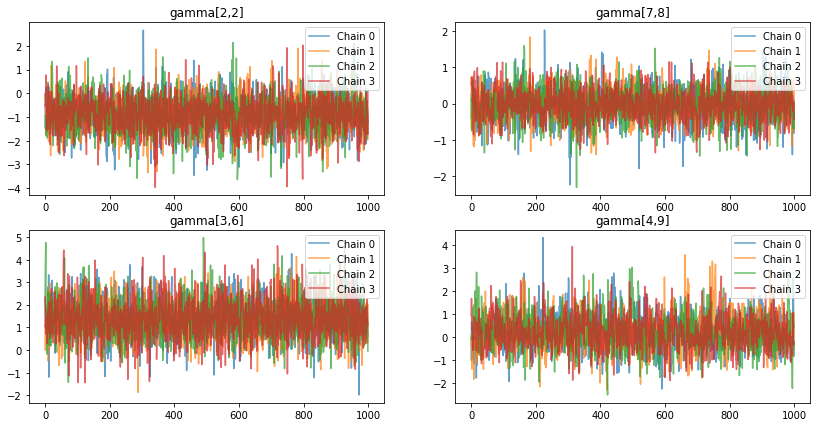

In [7]:
glicko_mcmc, score_pp_mcmc = hmc(glicko_stan, observed_data)

We see that chains, of each random variable, are mixed together potentially forming $R$ values close to $1$. To test our hypothesis, we take a closter look at two of these r.v.s:

In [8]:
candidate_parameters = ["gamma[2,2]", "gamma[7,8]"]
print(glicko_mcmc.summary().loc[candidate_parameters])

             Mean   MCSE  StdDev    5%    50%  95%   N_Eff  N_Eff/s  R_hat
name                                                                      
gamma[2,2]  0.094  0.012    0.78 -1.20  0.099  1.3  4144.0      5.7    1.0
gamma[7,8]  1.100  0.013    0.82 -0.26  1.000  2.4  4074.0      5.6    1.0


### 2. Mean-Field Variational Inference (VI)

In this section, we use mean-field variational family to approximate the intractavle posterior distribution. The training procedure and a convergence metric, namely **ELBO** by iteration, are as follows:

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


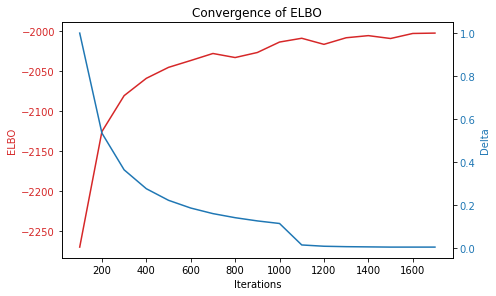

In [9]:
glicko_vi, score_pp_vi = meanfield_vi(glicko_stan, observed_data)

The **ELBO** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

### 3. Maximum a-posteriori Inference (MAP)

In this section, we model the intractable posterior distribution using a Dirac-delta function. This leads to MAP estimate for model parameters:

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


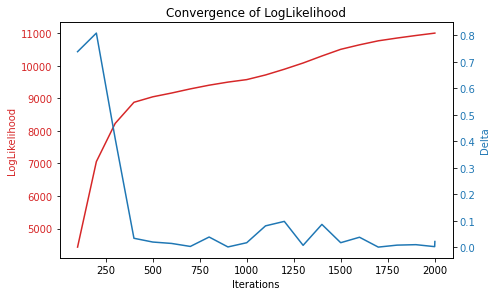

In [10]:
glicko_map, score_pp_map = map_opt(glicko_stan, observed_data)

The **LogLikelihood** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

### 4. Glicko2 Algorithm

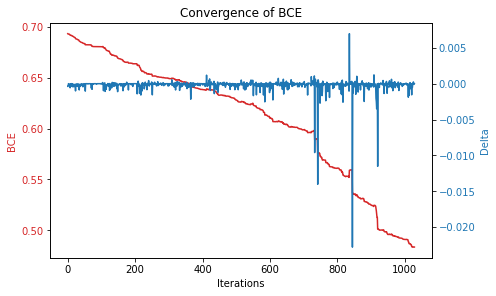

In [11]:
score_pp_glickman, test_probs = glickman(observed_data)

The Bernoulli likelihood of Glickman's algorithm monotonically decreases as we perform numberical updates. We observe that the variance of $\Delta$s are larger compared to the previous gradient based algorithms.

## Criticism  <a id='Criticism'></a>

We criticize our inference algorithms using posterior predictive checks (PPC). Moving forward, we compare the algorithms with each other using the predictions generated by the posterior predictive distribution (for MCMC, VI, and Glickman's algorithm) and point estimates (for MAP algorithm).

In [12]:
from criticism.criticism import plot_ppc

dim = 'period'
check = ['Sum', 'Min','Max']

### 1. Posterior Predictive Checks:

It is often challenging to make posterior predictive checks for discrete distribution, especially for Bernoulli distribution as its support is in $\{0, 1\}$. That's why we followed [Gelman (2000)](http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf) approach to carefully craft our test statistics as follows

1. $X_{total}^{emp}$: Average number of total white player wins across periods. 

   $X_{total}^{syn}$: Average number of total white player wins across periods, predicted by model. 
   
2. $X_{min}^{emp}$: Minimum of total white player wins across periods. 

   $X_{min}^{syn}$: Minimum of total white player wins throughout all periods, predicted by model. 
   
3. $X_{max}^{emp}$: Maximum of total white player wins across periods.

   $X_{max}^{syn}$: The maximum of total white player wins across periods, predicted by model.
   
We are interested in $P(T(X_{stats}^{synt}) > T(X_{stats}^{emp}))$, where $T$ changes w.r.t. above items. As an example,  $T$ is the function that takes the average number of total white player wins across periods for the first case.

**a. HMC Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **HMC** algorithm:

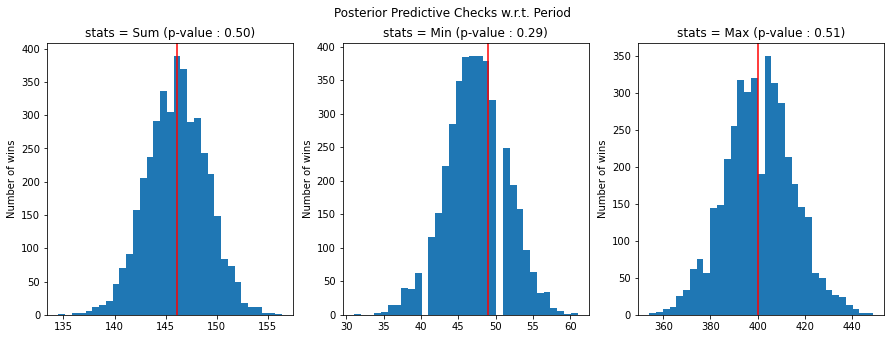

In [13]:
plot_ppc(score_pp_mcmc, observed_data, check, dim)

The simulated and generated data are good fit in terms of stats=Sum and stats=Max. However, the distribution of stats=Min is right-skewed which may indicate there may be improvement opportunities in the model.

**b. Meanfield VI Algorithm**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **Mean-field VI** algorithm:

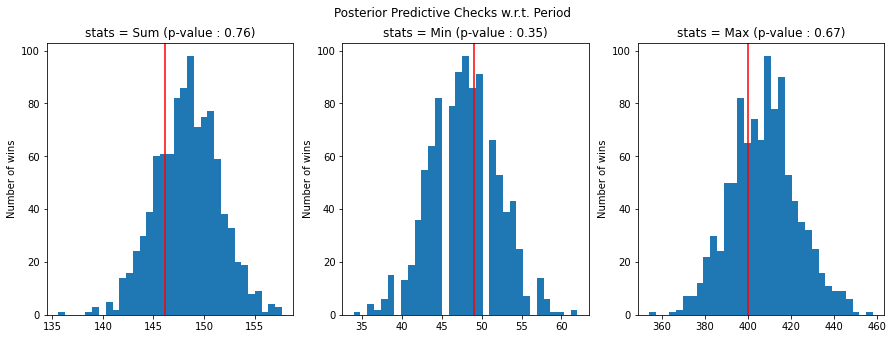

In [14]:
plot_ppc(score_pp_vi, observed_data,check, dim)

The simulated and generated data are good fit in terms of stats=Max. However, for stats=Min and stats=Sum, we observe slightly off results for stats=Sum, and stats=Min. This may be due to the simple, mean-field, variational approximation that we are using. 

### 2. Performance Comparisons:

We compare inference algorithms among each other using two metrics: binary cross entropy loss (BCE), and misclassification error (ME) as shown below. Note that, lower BCE and ME are better. 

In [15]:
from criticism.criticism import evaluate_models

evaluate_models(
    y=observed_data["score_test"],
    model_MCMC=glicko_mcmc, 
    model_VB=glicko_vi, 
    model_MLE=glicko_map,
    model_glicko=test_probs
)

,binary cross entropy loss $$- \dfrac{1}{n} \sum y \times log(y_{pred}) + (1-y) \times log(1 - y_{pred}) $$,misclassification error $$1 - \dfrac{1}{n} \sum \text{I} \{y = y_{pred}\} $$
,,
MCMC (HMC),0.578000,0.287000
MAP (L-BFGS),0.584000,0.287000
VB (Meanfield),0.604000,0.330000
Glicko2 (Original),0.564000,0.330000


We see that Glickman's algorithm performs better than other algorithms in BCE metric. However, MAP inference and HMC perform better than the rest of the algorithms in terms of ME. This, potentially, indicates that the model trained with Glickman's algorithm is more sure about its predictive probability when it is right.

## Re-Iteration  <a id='Re-Iteration'></a>

We re-iterate overthe Box's loop, focusing on inference. Specifically, we try improving the BCE score of MAP estimation by trying different hyperparameters:

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


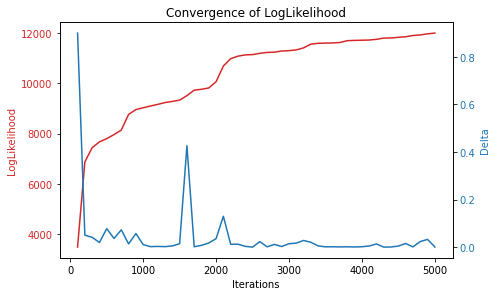

In [22]:
glicko_map, score_pp_map = map_opt(
    glicko_stan,
    observed_data,
    iter=5000,
    tol_obj=1e-13,
    tol_rel_obj=1e3,
    tol_grad=1e-9,
    tol_rel_grad=1e8,
    tol_param=1e-9,
    history_size=4
)

In our re-iteration, we observe that the default parameters of stan concerning iteration was not sufficient for convergence. We see that once number of iterations were increased MAP inference could beat Glickman's algorithm.

In [23]:
evaluate_models(
    y=observed_data["score_test"],
    model_MCMC=glicko_mcmc, 
    model_VB=glicko_vi, 
    model_MLE=glicko_map,
    model_glicko=test_probs
)

,binary cross entropy loss $$- \dfrac{1}{n} \sum y \times log(y_{pred}) + (1-y) \times log(1 - y_{pred}) $$,misclassification error $$1 - \dfrac{1}{n} \sum \text{I} \{y = y_{pred}\} $$
,,
MCMC (HMC),0.578000,0.287000
MAP (L-BFGS),0.559000,0.287000
VB (Meanfield),0.604000,0.330000
Glicko2 (Original),0.564000,0.330000


However, although MAP inference can beat Glickman's algorithm, in practice we are interested in low-latency (real-time) rankings. Yet, unlike Glickman's fast update algorithms, MAP inference requires training the model again which may be slower for practical apprications.